# Prob 3

Kalman filter: OLS duration smoothing, use 20-day OLS as input, decide on ONE set of parameters(If use EM, please use a rolling/extending window to do that)

In [1]:
from __future__ import print_function,division 
from pykalman import KalmanFilter
from numpy import linalg
import numpy as np
import pandas as pd
from scipy import poly1d

from collections import defaultdict
import itertools

#from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import math
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 
import time
import datetime
import scipy.interpolate as ie

import statsmodels.tools.tools as stt

/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read the data 

In [80]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2008-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

coupon = 4.5

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

full_dates = data.index
ret_dates = data.index[1:]

moneyness = coupon/100 - rates

tenor=10
swp_dur = pd.read_csv('tsy5y+10y.csv',index_col=0, header=0, skiprows=0)['10 year note Current Modified Duration']
swp_dur=pd.DataFrame(np.array(swp_dur),columns=['swap_duration'],index=swp_dur.index)
swp_dur.index=pd.to_datetime(swp_dur.index, format='%d-%b-%y')
one_day_return = pd.read_excel('1day-return_USD10Y.xlsx',index_col=0, header=0) 
one_day_return.index=pd.to_datetime(one_day_return.index, format='%Y%m%d')


fut_data=pd.read_csv('treasury_future.csv',index_col=0, header=0, skiprows=0)
fut_dur=pd.DataFrame(np.array(fut_data['Duration']),columns=['fut_duration'],index=fut_data.index)
fut_dur.index=pd.to_datetime(fut_dur.index, format='%Y-%m-%d')

fut_price=pd.DataFrame(np.array(fut_data['Price']),columns=['fut_price'],index=fut_data.index)
fut_price.index=pd.to_datetime(fut_price.index, format='%Y-%m-%d')

In [81]:
test_data = pd.concat([data, one_day_return], join='inner',axis=1).iloc[1:].copy()
test_data['return'] = ret
test_data['ratio'] = test_data['data'] / test_data['return']
TBA_return = ret
instru_return = test_data['data']

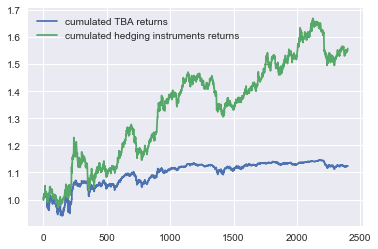

In [82]:
t_cum_return = np.cumprod(TBA_return + 1)
i_cum_return = np.cumprod(instru_return.values + 1)
plt.plot(t_cum_return,label='cumulated TBA returns')
plt.plot(i_cum_return, label='cumulated hedging instruments returns')
plt.legend()
plt.show()

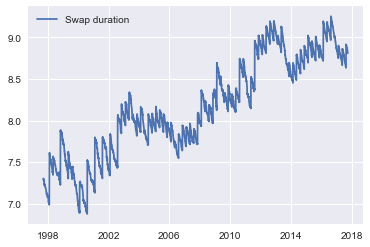

In [83]:
plt.plot(swp_dur,label='Swap duration')
plt.legend()
plt.show()

# Rolling windows


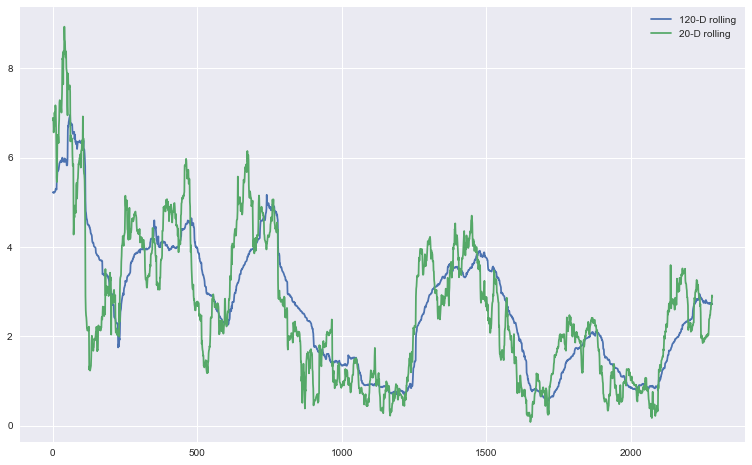

In [101]:
window_20 = 20
D_20_wInt = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = delta_r[t : t+window_20]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    D_20_wInt.append(- result.params[-1])
window_120 = 120
D_120_wInt = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    D_120_wInt.append(- result.params[-1])

plt.figure(figsize=(13,8))
plt.plot(D_120_wInt,label='120-D rolling')
plt.plot(D_20_wInt[100:], label='20-D rolling')
plt.legend()
plt.show()

In [88]:
window_120 = 120
D_120_wInt = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    D_120_wInt.append(- result.params[-1])
D_120_wInt=pd.DataFrame(D_120_wInt,columns=['D_120_wInt'],index=data.index[window_120+1:])

# Simple Kalman Filter using rolling Duration as observations


Here we assume we observed the D_20 duration, then we assume the intrinsic duration is the state and follow the simple rule:

\begin{align}
D^{rolling}_t &= D^{in}_t + v_t\\
D^{in}_{t+1} & = D^{in}_t + u_t
\end{align}

Both $v\sim N(0,0.1)$ and $u\sim N(0,0)$

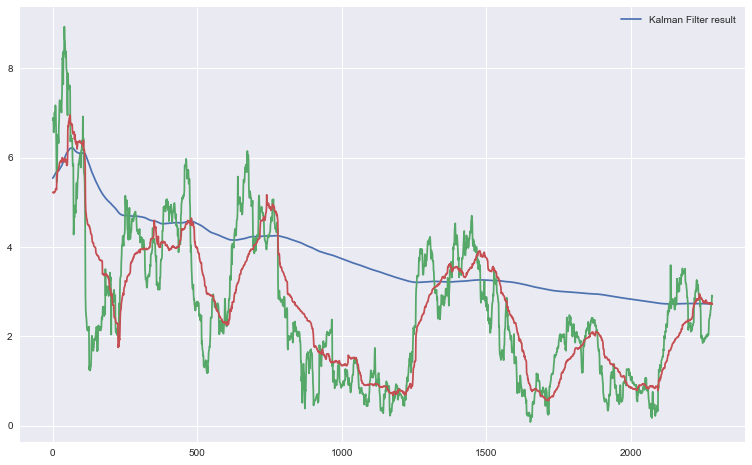

In [103]:
# Write Kalman Filter w/o package
plt.figure(figsize=(13,8))
filtered = [D_20_wInt[0]]
R = 1
p = 1
for i in D_20_wInt[1:]:
    K = p /(p + R)
    filtered.append(filtered[-1] + K * (i - filtered[-1]))
    p = (1 - K) * p

plt.plot(filtered[100:],label='Kalman Filter result')
plt.plot(D_20_wInt[100:])
plt.plot(D_120_wInt)
plt.legend()
plt.show()

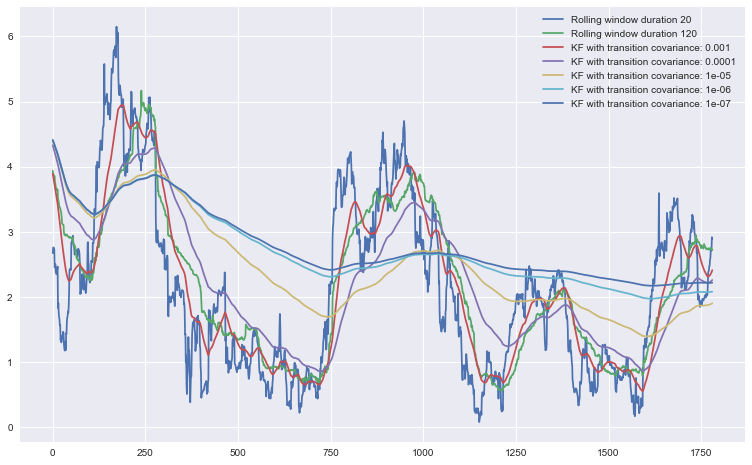

In [42]:
tran_cov = [1e-3,1e-4,1e-5,1e-6,1e-7]
plt.figure(figsize=(13,8))
plt.plot(D_20_wInt[100:],label = 'Rolling window duration 20')
plt.plot(D_120_wInt,label = 'Rolling window duration 120')
for cov in tran_cov:
    kf = KalmanFilter(initial_state_mean=0,initial_state_covariance=1,
        observation_matrices = 1,
                      transition_matrices = 1,
                      transition_covariance = cov,
                     observation_covariance = 1)

    state_mean_beta,_ = kf.filter(D_20_wInt)
    plt.plot(state_mean_beta[100:], label = 'KF with transition covariance: '+str(cov))
plt.legend()
plt.show()

# A little bit complex case using two set of state variables

\begin{align}
D^{roll}_t &= \alpha D^{in}_t + \beta M_t + \epsilon_t\\
D^{in}_t &= D^{in}_{t-1} + v_t\\
M_t &= m_t + u_t\\
\end{align}


Next we find the roughly beta. From a general regression method we could give a rough estimated beta of -31.0356

In [52]:
xx = np.array(D_20_wInt) - np.mean(D_20_wInt)
Ke = sm.OLS(xx , m)
res = Ke.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     236.0
Date:                Tue, 10 Oct 2017   Prob (F-statistic):           2.94e-50
Time:                        13:02:29   Log-Likelihood:                -3188.2
No. Observations:                1881   AIC:                             6378.
Df Residuals:                    1880   BIC:                             6384.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -31.0356      2.020    -15.361      0.000     -34.998     -27.073
==============================================================================
Omnibus:                      141.534   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.083
Skew:                           0.590   Prob(JB):                     1.26e-29
Kurtosis:                       2.448   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
obs_cov = [10,100,1000,1e4,20000]
tran_mat = np.matrix([[1,0],[0,0]])
m  = (moneyness[21:])

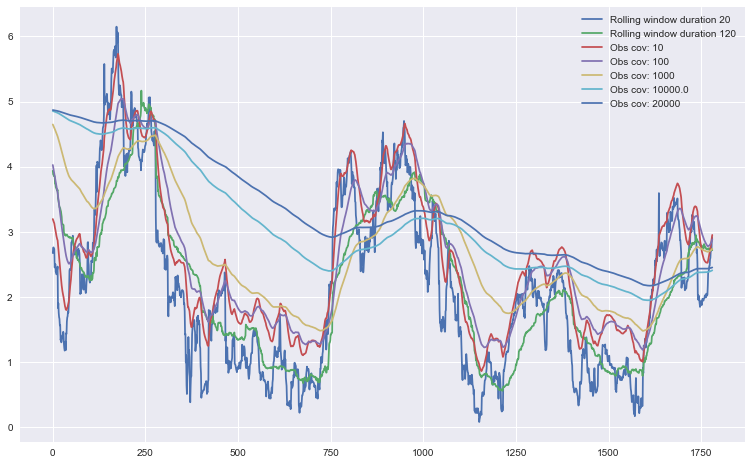

In [53]:
plt.figure(figsize=(13,8))
plt.plot(D_20_wInt[100:],label = 'Rolling window duration 20')
plt.plot(D_120_wInt,label = 'Rolling window duration 120')
for ob in obs_cov:
    kFF = KalmanFilter(initial_state_mean= [D_20_wInt[0],0],
                      initial_state_covariance = np.matrix([[0.01,0],[0,0]]),
                      observation_matrices = np.matrix([1,-31.0356]),
                      observation_covariance = ob,
                      transition_matrices = tran_mat,
                      transition_covariance = np.matrix([[0.1,0],[0,0.001]]),
                      transition_offsets = np.vstack((np.zeros_like(m),m)).T)

    smb,_= kFF.filter(D_20_wInt)
    plt.plot(smb[100:,0],label='Obs cov: '+str(ob))
    
plt.legend()
plt.show()

## Hedging ratio and results


In [57]:
# this function will return a dataframe which contains heding ratios and prices for each both original and hedging instruments
# dur1: duration of instrument to be hedged
# dur2: duration of hedging instrument
# price1: price of instrument to be hedged
# price2: price/return of hedging instrument
# ten_yr_treasury: 10y treasury rates used to calculate correlation
def data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury):
    data1=dur1.copy()
    data1.columns = ['dur1']
    
    data2=dur2.copy()
    data2.columns = ['dur2']
    
    data3=price1.copy()
    data3.columns = ['price1']
    
    data4=price2.copy()
    data4.columns = ['price2']
    
    # version 1: use abs change in decimal for interest rate change
    data5=pd.DataFrame((ten_yr_treasury.values[1:]-ten_yr_treasury.values[:-1])/100,index=ten_yr_treasury.index[1:])
    # version 2: use rel change for interest rate change
    # data5=pd.DataFrame((ten_yr_treasury.values[1:]-ten_yr_treasury.values[:-1])/(ten_yr_treasury.values[:-1]),index=ten_yr_treasury.index[1:])
    data5.columns = ['rate_change']
    
    result=data1.copy()
    result=result.merge(data2, left_index=True, right_index=True, how='inner')
    result=result.merge(data3, left_index=True, right_index=True, how='inner')
    result=result.merge(data4, left_index=True, right_index=True, how='inner')
    result=result.merge(data5, left_index=True, right_index=True, how='inner')
    
    result['hedge_ratio']=result['dur1']*result['price1']/result['dur2']/result['price2']
    
    return result

# hedge_info: DataFrame contains information dur1, dur2, price1, price2, rate_change and hedge_ratio
# startDat: the first day we want to start heding, it will be set to be the first day with available data
# window: window to calculate rolling correlation
# notional: notional amt for swap, if using another TBA as heding instrument, then this value will be omitted
# if_TBA_hedge: indicator is hedging instrument is another TBA
def hedge_perform(hedge_info,window=252,notional=100,startDate=np.nan):
    
    first_date=hedge_info.index[0]
    if startDate!=np.nan:
        first_date=max(first_date,pd.to_datetime(startDate, format='%Y-%m-%d'))
    
    for i,dataDate in enumerate(hedge_info.index):
        if dataDate >= first_date and len(hedge_info.index[i:])>1:
            
            new_hedge_info=hedge_info.iloc[i:,:]
            d0=new_hedge_info.index[0] # this is the date of heding ratio
            nakedR=[np.nan]
            hedgingR=[np.nan]
            portfolioR=[np.nan]
            portfolio_IR=[np.nan]
            portfolio_corr=[np.nan]
            
            for j,d in enumerate(new_hedge_info.index[1:]):
                # d is the date of hedging which is one day after d0
                hedgeRatio=new_hedge_info['hedge_ratio'].loc[d0]
                nakedReturn = new_hedge_info['price1'].loc[d]-new_hedge_info['price1'].loc[d0]
                hedgingReturn = (new_hedge_info['price2'].loc[d]-new_hedge_info['price2'].loc[d0])*hedgeRatio
                portfolioReturn = nakedReturn - hedgingReturn
                    
                nakedR.append(nakedReturn)
                hedgingR.append(hedgingReturn)
                portfolioR.append(portfolioReturn)
                
                if j >= window:
                    IR=252*np.mean(portfolioR[j-window:j])/np.std(portfolioR[j-window:j])
                    corr=np.corrcoef(portfolioR[j-window:j],np.array(new_hedge_info['rate_change'][j+1-window:j+1]))[0,1]
                else:
                    IR=np.nan
                    corr=np.nan
                    
                portfolio_IR.append(IR)
                portfolio_corr.append(corr)
                d0=d
             
            new_hedge_info['naked_return']=nakedR
            new_hedge_info['hedging_return']=hedgingR
            new_hedge_info['portfolio_return']=portfolioR
            new_hedge_info['portfolio_IR']=portfolio_IR
            new_hedge_info['portfolio_corr']=portfolio_corr
            break
            
    plot_result(new_hedge_info,window)
    
    return new_hedge_info

# this function plot heding performance
def plot_result(new_hedge_info,window):
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, np.cumsum(new_hedge_info['naked_return']),color='r',label='naked return')
    plt.plot(new_hedge_info.index, np.cumsum(new_hedge_info['hedging_return']),color='gold',label='hedging return')
    plt.plot(new_hedge_info.index, np.cumsum(new_hedge_info['portfolio_return']),color='g',label='hedged portfolio return')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Accumulative Return ($)',fontsize=14)
    plt.title('Hedging Performance - Accumulated Return',fontsize=14)
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, new_hedge_info['hedge_ratio'],color='c',label='hedging ratio')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Hedging Ratio',fontsize=14)
    plt.title('Hedging Performance - Hedging Ratio',fontsize=14)
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, new_hedge_info['portfolio_IR'],color='b',label='rolling IR for window '+str(window))
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('IR',fontsize=14)
    plt.title('Hedging Performance - IR',fontsize=14)
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, new_hedge_info['portfolio_corr'],color='orange',label='rolling correlation for window '+str(window))
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Correlation',fontsize=14)
    plt.title('Hedging Performance - Correlation between Hedged Portfolio Return and Interest Rate Change',fontsize=14)
    plt.legend(fontsize=14)

In [91]:
print(len(D_120_wInt))
len(data)-121

#D_120 = pd.DataFrame(D_120_wInt,index=data.index[121:])
D_20 = pd.DataFrame(D_20_wInt,index=data.index[21:])

2282


,dur1,dur2,price1,price2,rate_change,hedge_ratio,naked_return,hedging_return,portfolio_return,portfolio_IR,portfolio_corr
2008-02-01,3.276806,5.69369,97.111530,117.04688,0.00028,0.477494,NaN,NaN,NaN,NaN,NaN
2008-02-04,3.239231,5.69134,96.807651,116.81250,0.00092,0.471680,-0.303879,-0.111915,-0.191964,NaN,NaN
2008-02-05,3.190602,5.69625,97.298222,117.43750,-0.00133,0.464068,0.490571,0.294800,0.195771,NaN,NaN
2008-02-06,3.197889,5.69568,96.968750,117.31250,0.00092,0.464093,-0.329472,-0.058009,-0.271463,NaN,NaN
2008-02-07,3.213319,5.68918,96.209280,116.53125,0.00162,0.466314,-0.759470,-0.362573,-0.396897,NaN,NaN


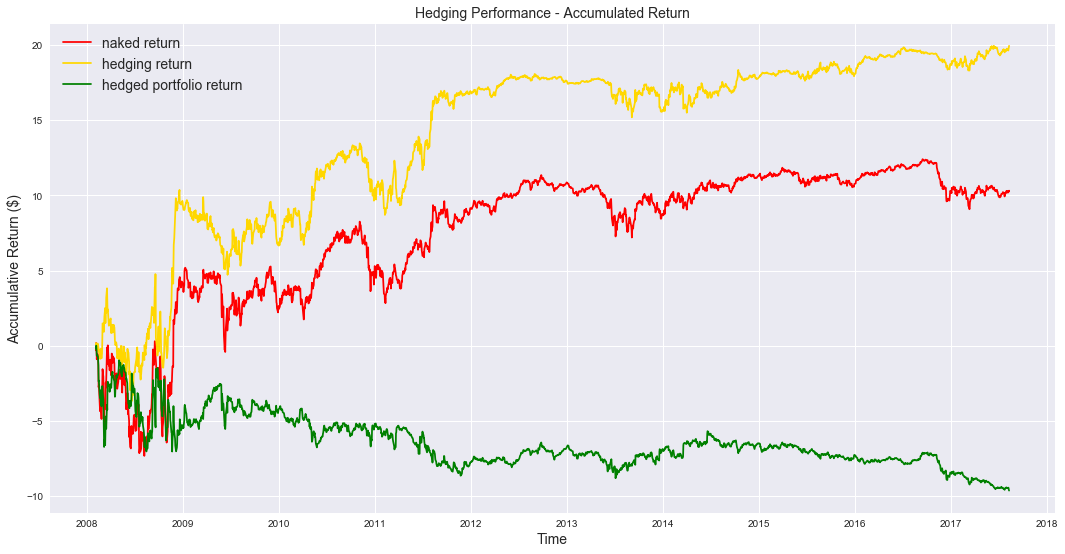

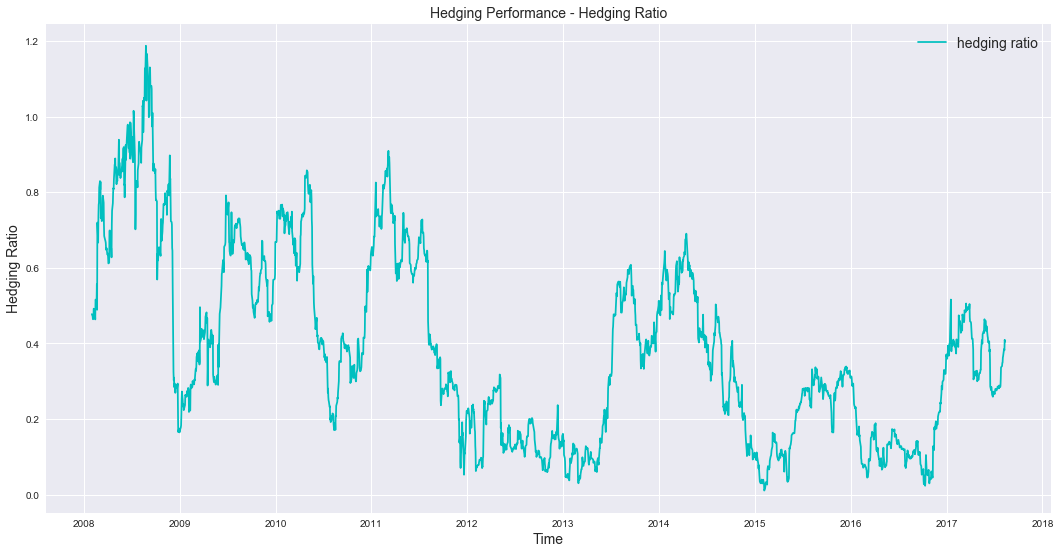

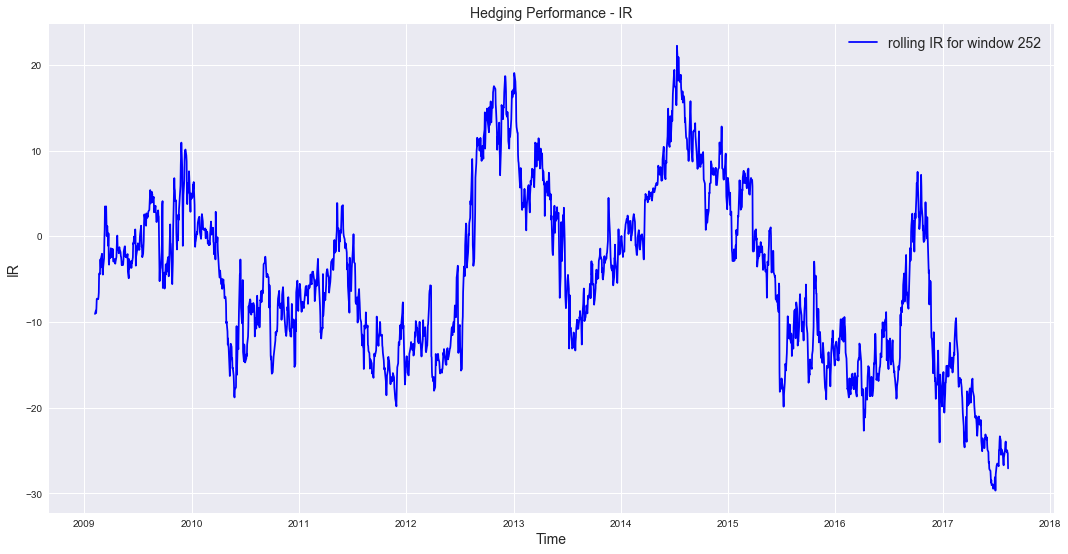

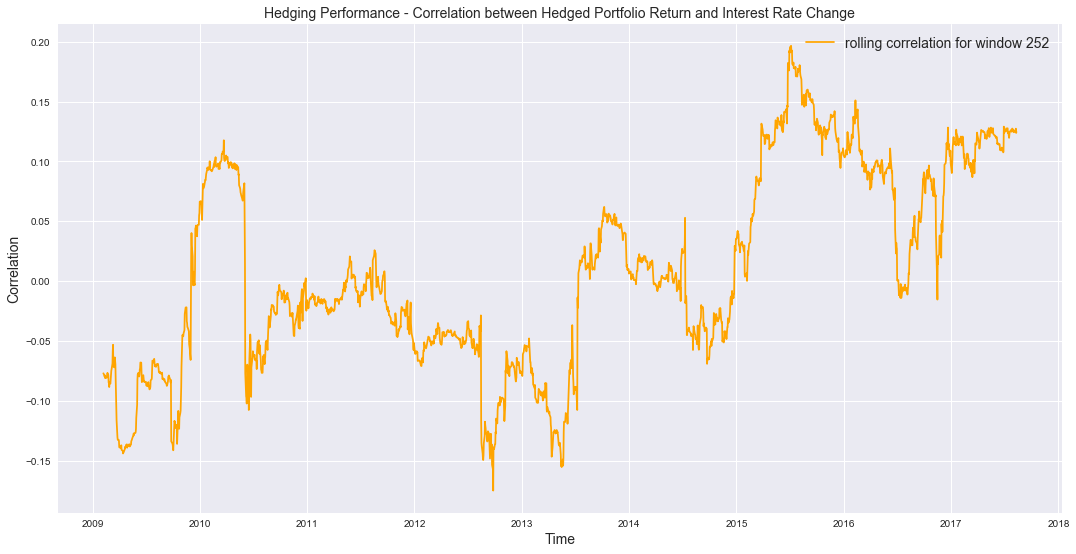

In [99]:
# data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury)

hedge_info=data_merge_for_hedging(D_20,fut_dur,pd.DataFrame(TBAs[4.5]['price']),fut_price,rate_Base)

# hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2008-01-01')
hedge_result.head()

,dur1,dur2,price1,price2,rate_change,hedge_ratio,naked_return,hedging_return,portfolio_return,portfolio_IR,portfolio_corr
2008-02-01,1.638403,5.69369,97.111530,117.04688,0.00028,0.238747,NaN,NaN,NaN,NaN,NaN
2008-02-04,2.172083,5.69134,96.807651,116.81250,0.00092,0.316288,-0.303879,-0.055958,-0.247922,NaN,NaN
2008-02-05,2.426796,5.69625,97.298222,117.43750,-0.00133,0.352974,0.490571,0.197680,0.292891,NaN,NaN
2008-02-06,2.581104,5.69568,96.968750,117.31250,0.00092,0.374582,-0.329472,-0.044122,-0.285350,NaN,NaN
2008-02-07,2.686568,5.68918,96.209280,116.53125,0.00162,0.389873,-0.759470,-0.292643,-0.466827,NaN,NaN


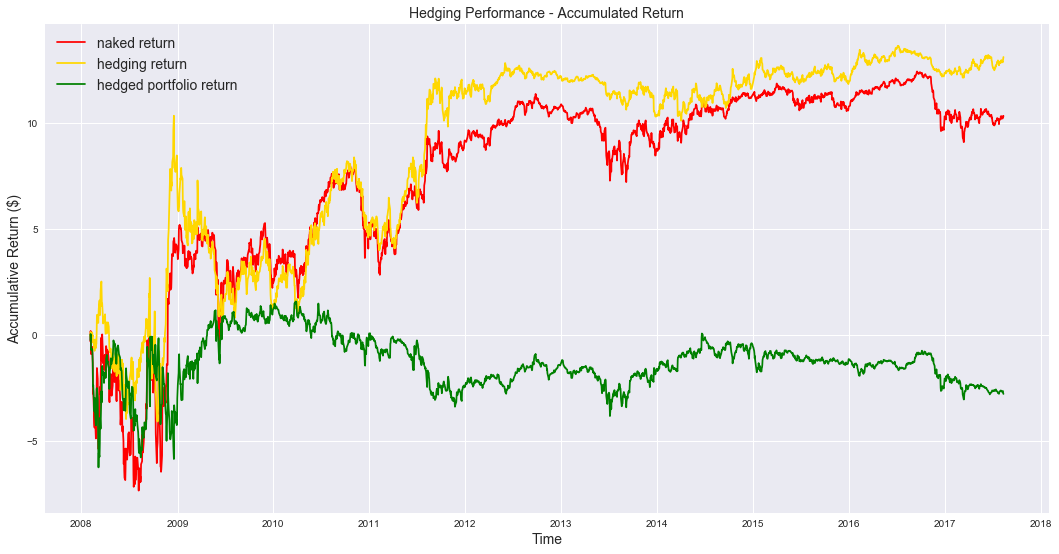

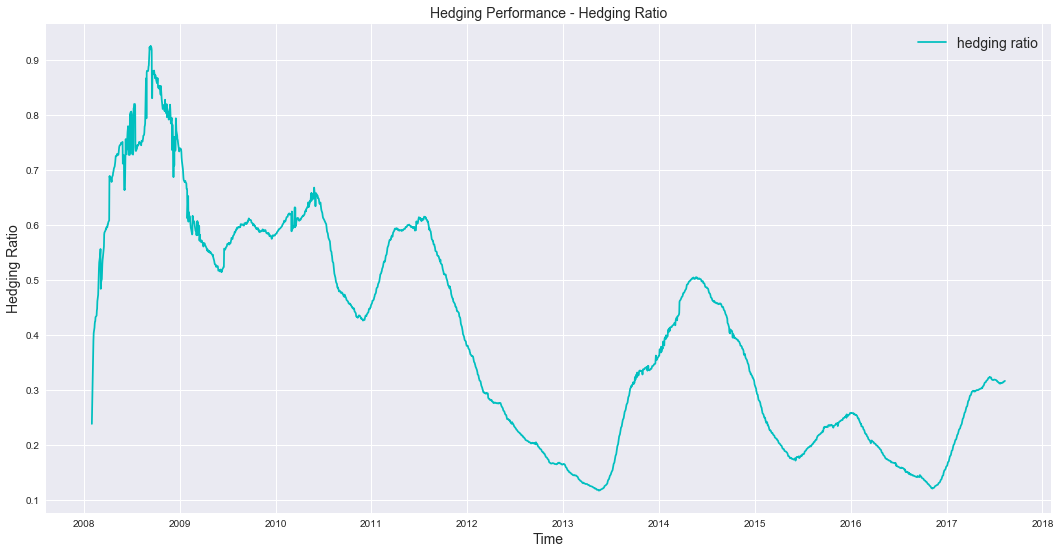

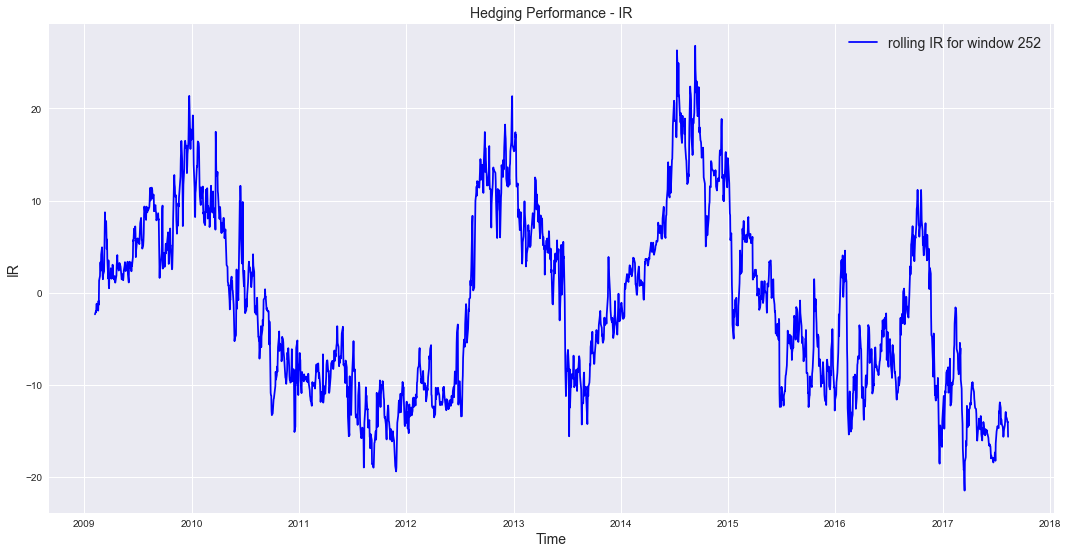

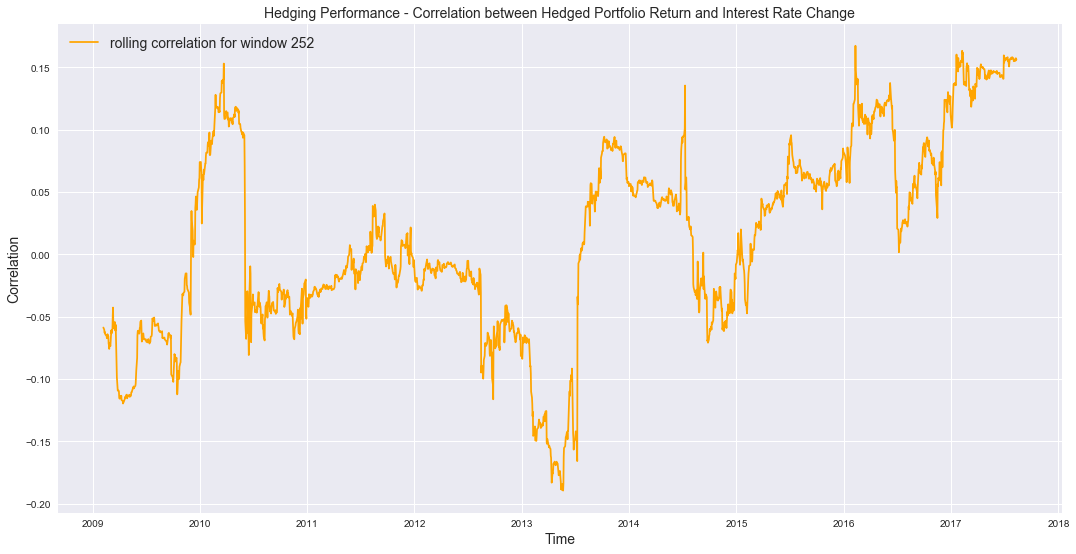

In [92]:
cov = 0.0001
kf = KalmanFilter(initial_state_mean=0,initial_state_covariance=1,
    observation_matrices = 1,
                  transition_matrices = 1,
                  transition_covariance = cov,
                 observation_covariance = 1)

state_mean_beta,_ = kf.filter(D_20_wInt)
KF_1 = pd.DataFrame(state_mean_beta,index=data.index[21:])
# data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury)

hedge_info=data_merge_for_hedging(KF_1,fut_dur,pd.DataFrame(TBAs[4.5]['price']),fut_price,rate_Base)

# hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2008-01-01')
hedge_result.head()

,dur1,dur2,price1,price2,rate_change,hedge_ratio,naked_return,hedging_return,portfolio_return,portfolio_IR,portfolio_corr
2008-02-01,3.276806,5.69369,97.111530,117.04688,0.00028,0.477494,NaN,NaN,NaN,NaN,NaN
2008-02-04,3.276782,5.69134,96.807651,116.81250,0.00092,0.477148,-0.303879,-0.111915,-0.191964,NaN,NaN
2008-02-05,3.276720,5.69625,97.298222,117.43750,-0.00133,0.476594,0.490571,0.298218,0.192353,NaN,NaN
2008-02-06,3.276644,5.69568,96.968750,117.31250,0.00092,0.475523,-0.329472,-0.059574,-0.269898,NaN,NaN
2008-02-07,3.276539,5.68918,96.209280,116.53125,0.00162,0.475489,-0.759470,-0.371502,-0.387968,NaN,NaN


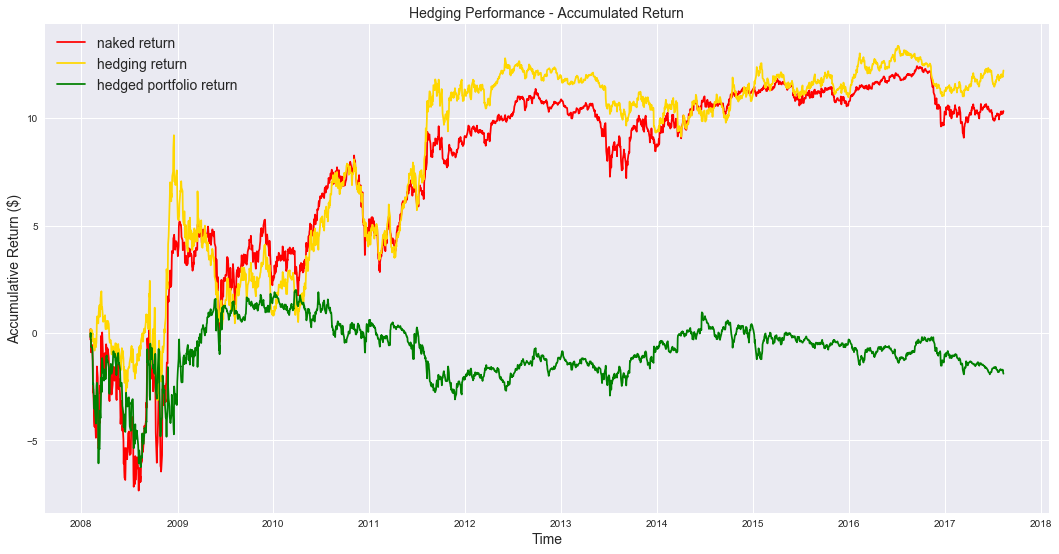

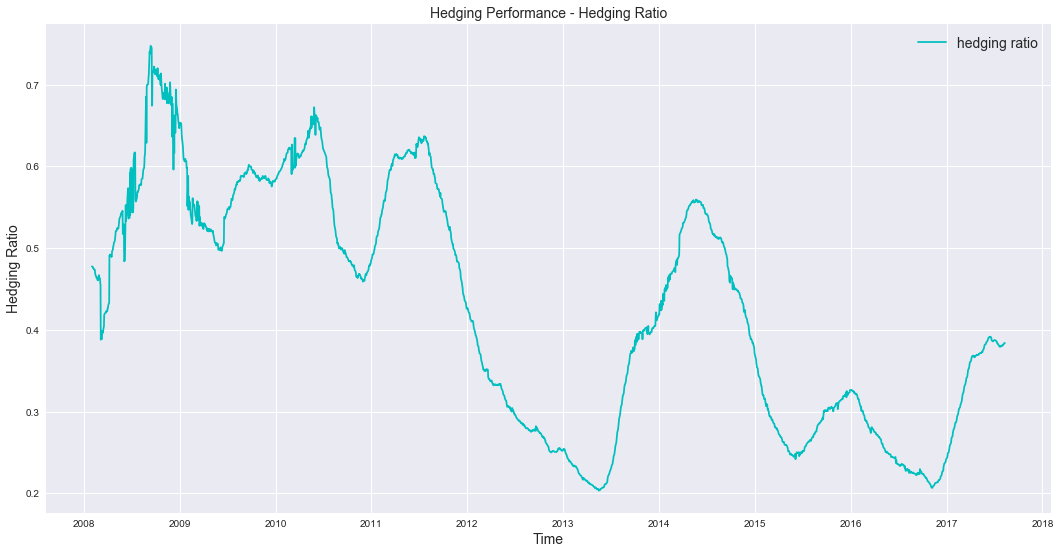

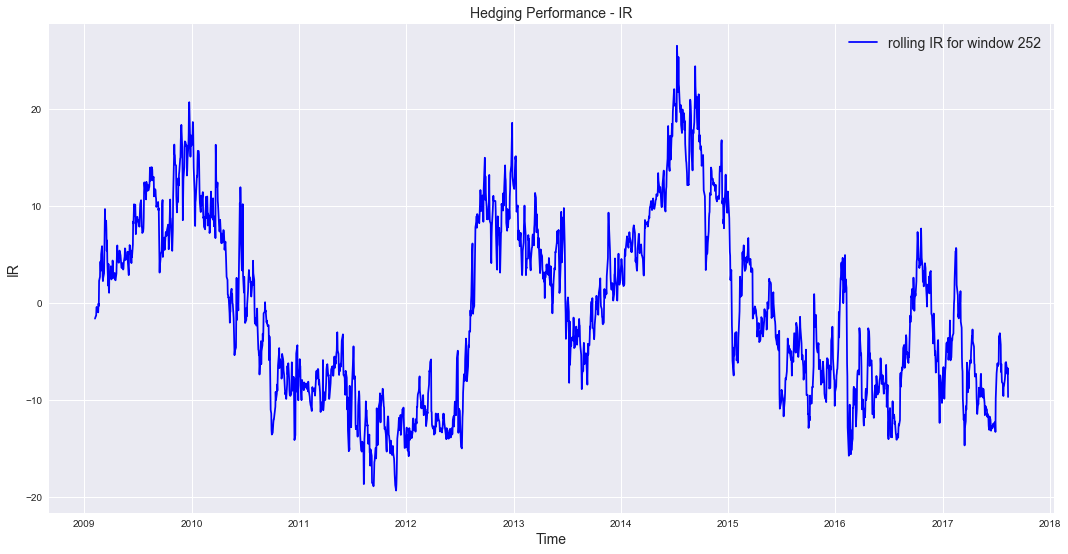

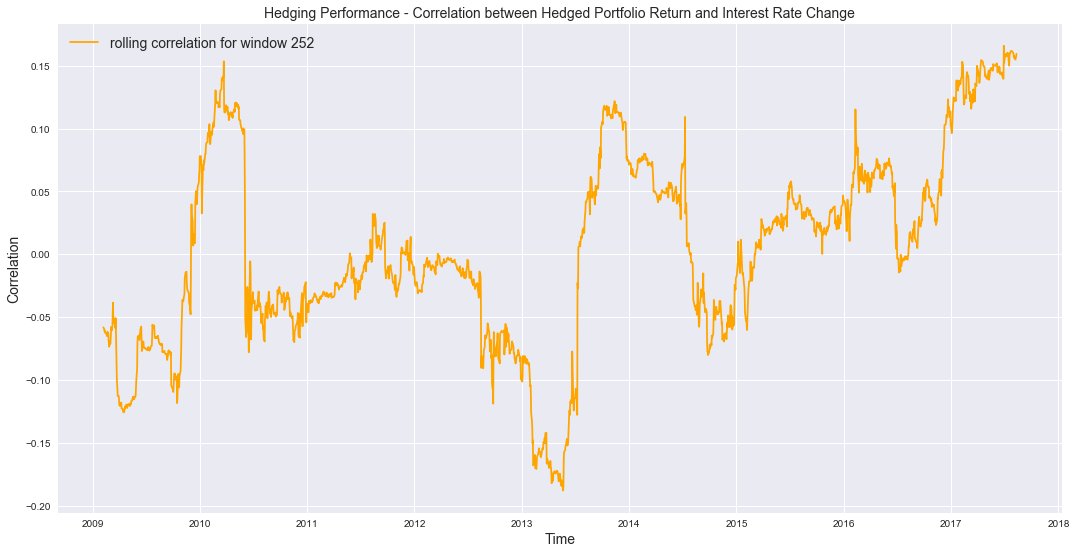

In [97]:
ob = 1000

kFF = KalmanFilter(initial_state_mean= [D_20_wInt[0],0],
                  initial_state_covariance = np.matrix([[0.01,0],[0,0]]),
                  observation_matrices = np.matrix([1,-31.0356]),
                  observation_covariance = ob,
                  transition_matrices = tran_mat,
                  transition_covariance = np.matrix([[0.1,0],[0,0.001]]),
                  transition_offsets = np.vstack((np.zeros_like(m),m)).T)

smb,_= kFF.filter(D_20)

KF_2 = pd.DataFrame(smb[:,0],index=data.index[21:])
# data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury)

hedge_info=data_merge_for_hedging(KF_2,fut_dur,pd.DataFrame(TBAs[4.5]['price']),fut_price,rate_Base)

# hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2008-01-01')
hedge_result.head()


# Prob 4

In [121]:
data2 = TBAs[4]['2008-01-01':]
data2.columns=['coupon4','price4','1','2','3']
df_t = pd.concat([data,data2],join='inner',axis=1)
T45 = df_t['price'].values
T4 = df_t['price4'].values

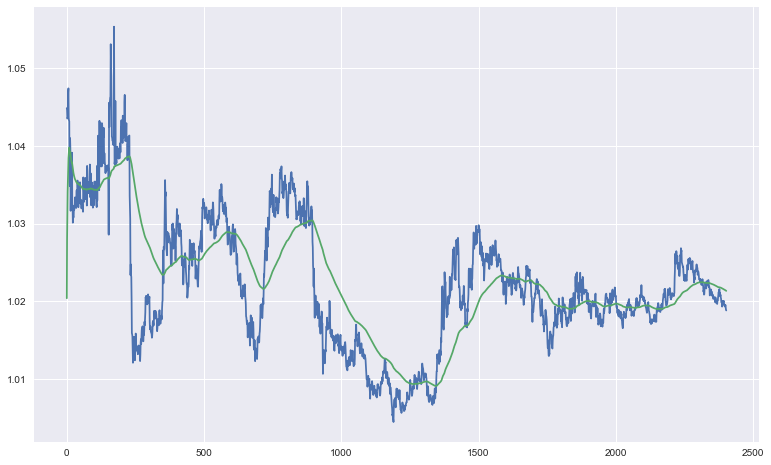

In [178]:
#obs_mat_r = np.expand_dims(np.vstack(obs_mat_raw).T, axis=1)
plt.figure(figsize=(13,8))
os_m = np.expand_dims(np.vstack((T4,np.ones_like(T4))).T,axis=1)
dim = 2
kf_r = KalmanFilter(initial_state_mean = [1,0],
          initial_state_covariance = np.matrix([[0.1,0],[0,0]]),

          transition_matrices = np.matrix([[1,0],[0,0]]),
          observation_matrices = os_m,

          observation_covariance = 1000,
          transition_covariance = np.matrix([[0.00001,0],[0,0]]))

res, _ = kf_r.filter(T45)
#kf_r = kf_r.em(y)
#res_m, _ = kf_r.filter(y
plt.plot(rati)
plt.plot(res[:,0])